## Module 3.1 - 1D flames

We are going to compute a 1D laminar premixed methane-air flame with a fixed equivalence ratio and visualise the results. This flame is a free flame, meaning that it is not attached to any geometry like a burner. This is similar to a mixture of fuel and air that burns in a cylindrical thermally isolated tube. If we ignite the mixture at the inlet at the left, the flame will propagate through the tube until it reaches the outlet  at the right. The propagation speed of the flame is the laminar flame speed $S_L$. The flame can be kept at a stationary position when the inlet velocity exactly matches the laminar flame speed. In these 1D free flame computations, the flame is kept at a fixed position and the inlet velocity that matches the flame speed is computed. 

In [1]:
%matplotlib inline
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

We compute a 1D laminar premixed flame of a methane-air mixture with an equivalence ratio of $\phi=0.8$. The domain length is 1 cm, but cantera will detect if this is too small and increase it automatically to fit the flame. Usually, 2 cm is sufficient for containing a flame at standard temperature and pressure. Compute the 1D flame and have a look at the intermediate output so you have an idea of what is going on. For long computations it is convenient to see some output every now and then so you know it is still actively computing something and not stuck somewhere. This computation should take about 30 seconds. 

In [2]:
# Simulation parameters
p = ct.one_atm  # pressure [Pa]
T_unburnt = 300.0  # unburned gas temperature [K]
width = 0.01  # width of the domain [m], this can increase during the computation

loglevel = 1  # amount of diagnostic output (0 to 8). Put to 0 if you do not want to see computational details

gas = ct.Solution('gri30.xml')

phi = 0.80
fuel_species = 'CH4'
air_composition='O2:0.21,N2:0.79'
gas.TP = T_unburnt,p
gas.set_equivalence_ratio(phi,fuel_species,air_composition)

# Set up flame object
f = ct.FreeFlame(gas, width=width)
# We start with a very coarse mesh, and do some local refinement during the computation
f.set_refine_criteria(ratio=10, slope=0.05, curve=0.10)
#f.show_solution()

# Solve with this transport model
f.transport_model = 'UnityLewis'
f.solve(loglevel=loglevel, auto=True)

# Store the laminar flame speed
SL = f.u[0]
# Max. temperature is final value
Tmax=f.T[len(f.T)-1]

print('Unity Lewis model flamespeed = {0:7f} m/s'.format(SL))
print('Unity Lewis model maximum temperature = {0:7f} m/s'.format(Tmax))


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.271e-05      5.323
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0007298      4.525
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.01247      3.011
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accomodate flame thickness. New width: 0.02 m
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 4 5 6 7 
    to resolve C2H2 C2H3 C2H4 C2H5 C2H6 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCNO HCO HNCO HO2 N2 N2O NCO NO NO2 O O2 OH T

If the computation was successful, the last lines will tell you that the Newton solution was a success, that the problem was solved on xxx grid points and what the flamespeed and flame temperature is. 
It is a numerical computation, so we have to make sure that our numerical error is small. Before analysing the results further, we will compute a second flame and investigate the effect of mesh refinement on the solution. We change the settings in *set_refine_criteria*. 

In [3]:
# Simulation parameters
p = ct.one_atm  # pressure [Pa]
T_unburnt = 300.0  # unburned gas temperature [K]
width = 0.01  # width of the domain [m]
loglevel = 0  # amount of diagnostic output (0 to 8)

gas = ct.Solution('gri30.xml')

phi = 0.80
fuel_species = 'CH4'
air_composition='O2:0.21,N2:0.79'
gas.TP = T_unburnt,p
gas.set_equivalence_ratio(phi,fuel_species,air_composition)

# Set up flame object
f2 = ct.FreeFlame(gas, width=width)

# we start with a very coarse mesh, and do some local refinement during the computation
f2.set_refine_criteria(ratio=10, slope=0.02, curve=0.04)
#f.show_solution()

# Solve with this transport model
f2.transport_model = 'UnityLewis'
f2.solve(loglevel=loglevel, auto=True)


SL2 = f2.u[0]
# Max. temperature is final value
Tmax2=f2.T[-1]

print('Unity Lewis model flamespeed = {0:7f} m/s'.format(SL2))
print('Unity Lewis model maximum temperature = {0:7f} m/s'.format(Tmax2))

Unity Lewis model flamespeed = 0.245671 m/s
Unity Lewis model maximum temperature = 2001.553685 m/s


In [4]:
print("number of points in mesh 1 = ",len(f.grid))
print("number of points in mesh 2 = ",len(f2.grid))
print('difference between old and new SL = ',SL/SL2)
print('difference between old and new Tf = ',Tmax/Tmax2)

number of points in mesh 1 =  186
number of points in mesh 2 =  431
difference between old and new SL =  1.003765462078892
difference between old and new Tf =  0.9994421281903196


We see that the difference in laminar flame speed and flame temperature is less than 1%. It is possible that the error is larger for other quantities. Let's see what the temperature looks like.

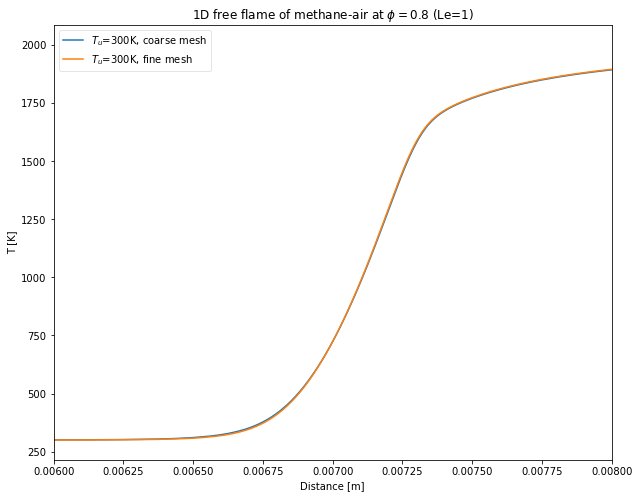

In [6]:
plt.figure()
# We can globally change the figure size 
plt.rcParams['figure.figsize'] = [10,8]
plt.xlim(0.006,0.008)
plt.plot(f.grid,f.T,label='$T_u$=300K, coarse mesh')
plt.plot(f2.grid,f2.T,label='$T_u$=300K, fine mesh')
plt.xlabel('Distance [m]')
plt.ylabel('T [K]')
plt.title('1D free flame of methane-air at $\phi=0.8$ (Le=1)')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper left')
plt.show()

We see that in the temperature profile, there is very little difference between the coarse and the fine mesh. 

In the unity Lewis number approach the total enthalpy should be constant in the domain. Remember that total enthalpy is sensible enthalpy + chemical (formation) enthalpy: $h_t = \int_{T_0}^{T}c_p dT + h_f$, and the chemical enthalpy is converted to sensible enthalpy (heat) during combustion. We will now check if the total enthalpy is conserved (should always be the case), and if it is constant in the domain (should be the case when $Le=1$). 

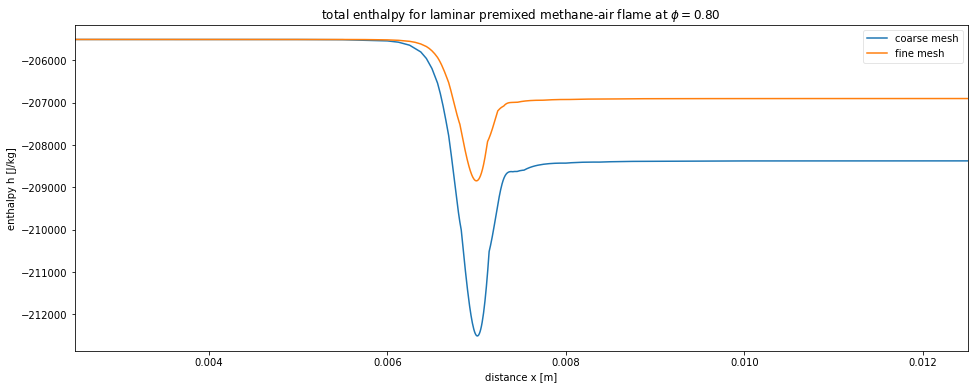

In [11]:
# Remember to always use a label with units for the axes, place a title with additional information and add a legend 
# if there is more than 1 line in the figure. 
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [16, 6]
plt.xlim(0.0025,0.0125)
plt.plot(f.grid,f.enthalpy_mass,'-',label='coarse mesh')
plt.plot(f2.grid,f2.enthalpy_mass,'-',label='fine mesh')
plt.xlabel('distance x [m]')
plt.ylabel('enthalpy h [J/kg]')
plt.title('total enthalpy for laminar premixed methane-air flame at $\phi=0.80$')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper right')
plt.show()

There is some difference between the enthalpy before and after the flame, and also a dip at the location of the flame. This is actually due to the numerical scheme, which does not conserve the total enthalpy. If a finer mesh is used, the enthalpy is more uniform and the enthalpy at the outlet will be closer to the inlet enthalpy. 

So how large is this 'problem' in reality? We have already seen little difference when comparing the laminar flame speed and the temperature profiles of the two solutions. Let's change the total enthalpy of the flame by increasing the initial temperature. We'll plot the total enthalpy of a free flame at $T_u=300 K$ and $T_u=400 K$.

In [13]:
# Simulation parameters
p = ct.one_atm  # pressure [Pa]

###################################################
T_unburnt = 400.0  # unburned gas temperature [K] #
###################################################

width = 0.01  # width of the domain [m]
loglevel = 0  # amount of diagnostic output (0 to 8)

gas = ct.Solution('gri30.xml')

phi = 0.80
fuel_species = 'CH4'
air_composition='O2:0.21,N2:0.79'
gas.TP = T_unburnt,p
gas.set_equivalence_ratio(phi,fuel_species,air_composition)

# Set up flame object
f_400 = ct.FreeFlame(gas, width=width)
# we start with a very coarse mesh, and do some local refinement during the computation
f_400.set_refine_criteria(ratio=10, slope=0.05, curve=0.10)
#f.show_solution()

# Solve with this transport model
f_400.transport_model = 'UnityLewis'
f_400.solve(loglevel=loglevel, auto=True)

SL = f_400.u[0]

# max temperature is final value
Tmax=f_400.T[-1]

print('mixture-averaged flamespeed = {0:7f} m/s'.format(SL))
print('mixture-averaged maximum temperature = {0:7f} m/s'.format(Tmax))

mixture-averaged flamespeed = 0.401550 m/s
mixture-averaged maximum temperature = 2067.794831 m/s


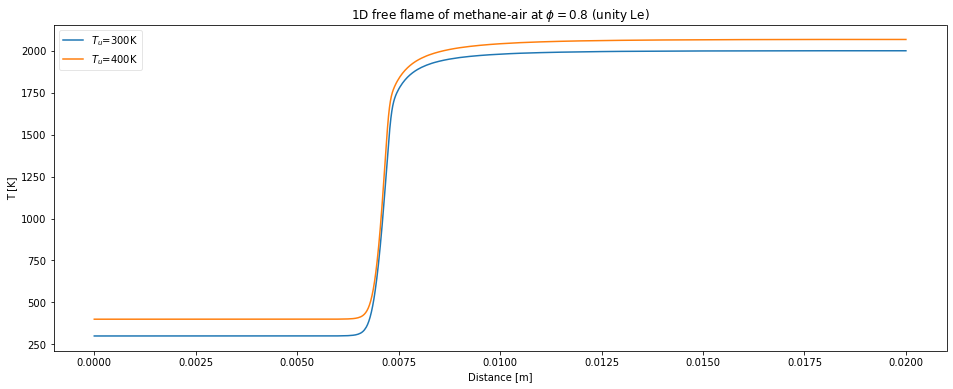

In [14]:
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [8, 4]
#plt.xlim(0.008,0.015)
plt.plot(f.grid,f.T,label='$T_u$=300K')
plt.plot(f_400.grid,f_400.T,label='$T_u$=400K')

plt.xlabel('Distance [m]')
plt.ylabel('T [K]')
plt.title('1D free flame of methane-air at $\phi=0.8$ (unity Le)')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper left')
plt.show()

We clearly see the impact of a temperature increase of the unburnt mixture on the entire temperature profile of the flame. You can also see the impact on the laminar flame speed. We will now plot the total enthalpy:

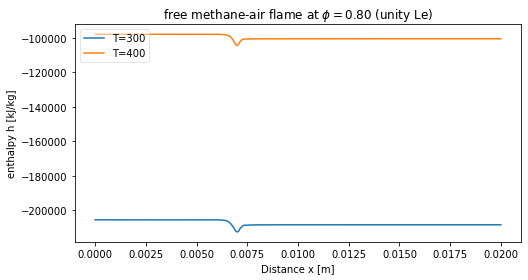

In [20]:
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [8, 4]
#plt.xlim(0.008,0.015)
plt.plot(f.grid,f.enthalpy_mass,label='T=300')
plt.plot(f_400.grid,f_400.enthalpy_mass,label='T=400')
plt.title('free methane-air flame at $\phi=0.80$ (unity Le)')
plt.xlabel('Distance x [m]')
plt.ylabel('enthalpy h [kJ/kg]')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper left')
plt.show()

We can see that the change in enthalpy due to the inlet temperature is much larger than the spatial enthalpy changes due to the enthalpy not being conserved. Because the enthalpy is not conserved, $h$ is slightly lower at the outlet, leading to an error in the temperature (and of course in everything else as well). We can compute the error as a temperature change by using the sensible enthalpy. We take the difference between the enthalpy at the inlet and the outlet and compute a temperature change using $h=\int_{T_0}^{T} c_p dT $ with constant $c_p$. We will then see a temperature difference of a few K. On a flame temperature of 2000 K, this is negligible. We can consider this total enthalpy constant.

If we would have used a nonunity Lewis model, the enthalpy will not be constant over the flame, but it should still be conserved. Let's have a look.

In [21]:
# Simulation parameters
p = ct.one_atm  # pressure [Pa]
T_unburnt = 300.0  # unburned gas temperature [K]
width = 0.01  # width of the domain [m]
loglevel = 0  # amount of diagnostic output (0 to 8)

gas = ct.Solution('gri30.xml')

phi = 0.80
fuel_species = 'CH4'
air_composition='O2:0.21,N2:0.79'
gas.TP = T_unburnt,p
gas.set_equivalence_ratio(phi,fuel_species,air_composition)

# Set up flame object
f_mix = ct.FreeFlame(gas, width=width)
# we start with a very coarse mesh, and do some local refinement during the computation
f_mix.set_refine_criteria(ratio=10, slope=0.05, curve=0.10)
#f.show_solution()

# Solve with this transport model
###################################################
f_mix.transport_model = 'Mix'
###################################################
f_mix.solve(loglevel=loglevel, auto=True)

SL = f_mix.u[0]

# max temperature is final value
Tmax=f_mix.T[-1]

print('mixture-averaged flamespeed = {0:7f} m/s'.format(SL))
print('mixture-averaged maximum temperature = {0:7f} m/s'.format(Tmax))

mixture-averaged flamespeed = 0.273106 m/s
mixture-averaged maximum temperature = 2000.326046 m/s


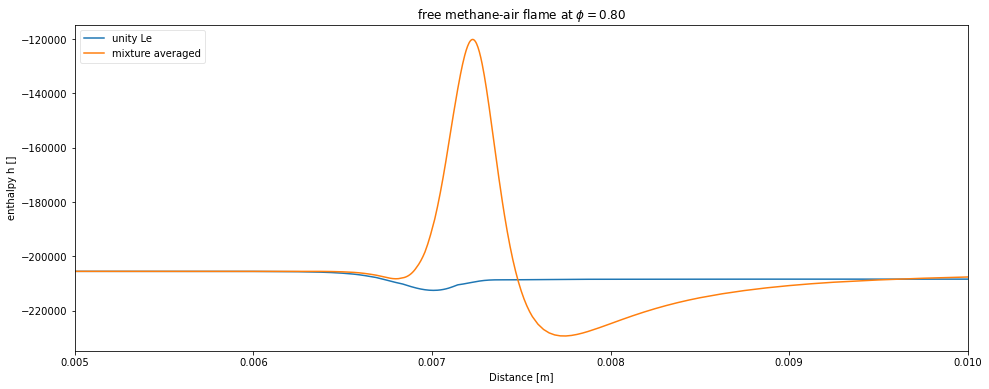

In [26]:
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [16, 6]
plt.xlim(0.005,0.01)
plt.plot(f.grid,f.enthalpy_mass,label='unity Le')
plt.plot(f_mix.grid,f_mix.enthalpy_mass,label='mixture averaged')
plt.title('free methane-air flame at $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('enthalpy h []')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper left')
plt.show()

We indeed see that in the flame, the (total) enthalpy changes, but the enthalpy is still conserved (almost). In a unity lewis model, all species diffuse equally fast. This is not the case for the other, more complex diffusion models. Since the local chemical enthalpy is the sum of the specific (species) enthalpies, the local enthalpy can change when the species all have different diffusivities (Lewis numbers).

Let's go back to the free flame solution and look at the species mole fractions. 

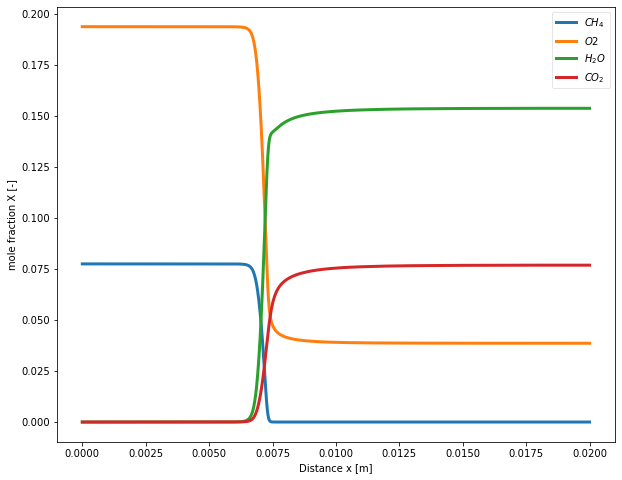

In [35]:
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [6, 8]
plt.rcParams['lines.linewidth']=3
#plt.xlim(0.01,0.03)
plt.plot(f.grid,f.X[gas.species_index('CH4')],label='$CH_4$')
plt.plot(f.grid,f.X[gas.species_index('O2')],label='$O2$')
plt.plot(f.grid,f.X[gas.species_index('H2O')],label='$H_2O$')
plt.plot(f.grid,f.X[gas.species_index('CO2')],label='$CO_2$')
plt.xlabel('Distance x [m]')
plt.ylabel('mole fraction X [-]')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper right')
plt.show()

That looks good, we see that methane and oxygen is consumed, and we have some oxygen left because we burn (fuel) lean with $\phi<1$. We also see that the entire reaction process is finished before the end of the domain. You might remember that the production of NO was a slow process and it also continues as long as the temperature is high. Let's check the result for NO.

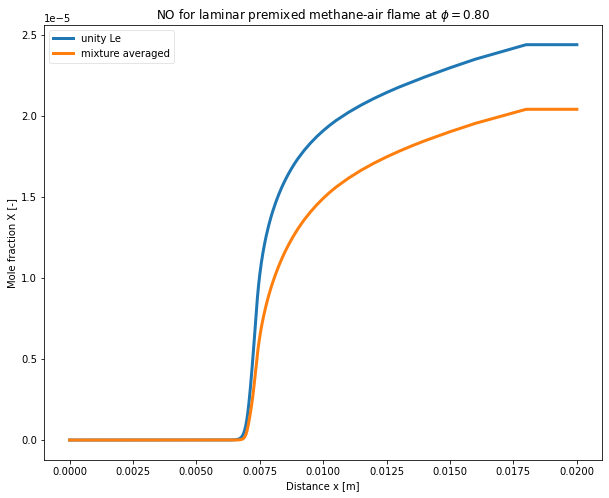

In [38]:
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [10, 8]
#plt.xlim(0.01,0.03)
plt.plot(f.grid,f.X[gas.species_index('NO')],label='unity Le')
plt.plot(f_mix.grid,f_mix.X[gas.species_index('NO')],label='mixture averaged')
plt.xlabel('Distance x [m]')
plt.ylabel('Mole fraction X [-]')
plt.title('NO for laminar premixed methane-air flame at $\phi=0.80$')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper left')
plt.show()

NO just continues to increase as long as the temperature is high and there is enough oxygen. It takes a long time to reach the equilibrium value. It slope suddenly goes horizontal close to the exit because of the Neumann boundary condition here. We also see a  difference due to the diffusion model. The mole fraction goes from $25\cdot 10^{-6}$ to $20\cdot 10^{-6}$ when switching from unity Le to a mixture averaged model, so from 25 ppm to 20 ppm (because mole fractions times $10^6$ is ppm). 

# burner stabilized flame

Instead of a free flame, we can also consider a burner stabilized flame. In this case, the flame speed does not need to be balanced exactly with the inlet velocity, but is instead stabilized on a cold burner. The temperature of the gas as it exits the burner is assumed to be equal to the burner temperature. The flame loses heat  to the burner, and the amount of heat loss depends on the burner temperature as well as the inlet velocity (or mass flow rate).  
A burner stabilized flame therefore needs the mass flow rate as a new parameter in the setup. In the setup below we choose a mass flow rate such that the heat loss is low and the total enthalpy is close to that of a free

In [40]:
"""
A burner-stabilized lean premixed methane-air flame.
"""

p = ct.one_atm
# we now assume a flame stabilized on a burner, the burner and the initial gas temperature 
# have the temperature of the burner. There is now a heat loss to the burner.
tburner = 300.0

phi = 0.8
fuel_species = 'CH4'
air_composition='O2:0.21,N2:0.79'

# The flame is now stabilized on the burner, so the mass flow rate (or velocity) can be different from 
# the laminar flame speed. The heat loss to the burner depends on the burner temperature and the 
# mass flow rate.
###################################################
mdot = 0.2
###################################################

#reactants = 'H2:1.5, O2:1, AR:7'  # premixed gas composition
width = 0.03 # m
loglevel = 1  

gas = ct.Solution('gri30.xml')

gas.TP = tburner,p
gas.set_equivalence_ratio(phi,fuel_species,air_composition)

###################################################
f_burner = ct.BurnerFlame(gas, width=width)
f_burner.burner.mdot = mdot
###################################################
f_burner.set_refine_criteria(ratio=3.0, slope=0.05, curve=0.1)
#f.show_solution()

f_burner.transport_model = 'UnityLewis'
f_burner.solve(loglevel, auto=True)
#f.save('ch4_burner_flame.xml', 'unitylewis', 'solution with unity lewis transport')
#f.write_csv('h2_burner_flame.csv', quiet=False)


************ Solving on 7 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.271e-05      5.294
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0007298      4.894
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.002771      3.748
Attempt Newton solution of steady-state problem...    success.

Problem solved on [7] point grid(s).

..............................................................................
grid refinement disabled.

******************** Solving with grid refinement enabled ********************

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [7] point grid(s).

..................................................

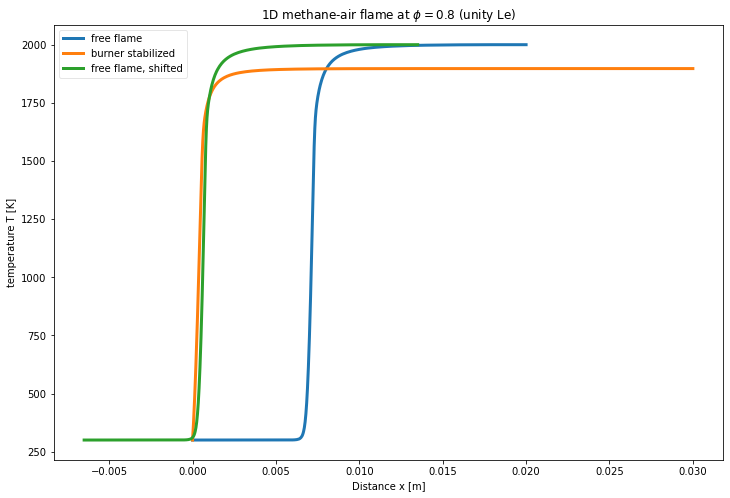

In [55]:
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [12, 8]
#plt.xlim(0.008,0.015)
plt.plot(f.grid,f.T,label='free flame')
plt.plot(f_burner.grid,f_burner.T,label='burner stabilized')
plt.plot(f.grid-0.0065,f.T,label='free flame, shifted')
plt.xlabel('Distance x [m]')
plt.ylabel('temperature T [K]')
plt.title('1D methane-air flame at $\phi=0.8$ (unity Le)')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper left')
plt.show()

The temperature profiles for the burner stabilized and the free flame look quite different. The burner stabilized flame is attached to the burner at x=0 and the temperature immediately rises to the flame temperature. Note that the free flame is arbitrarily positioned and it's exact location has no physical meaning. If we shift the temperature of the free flame to the left, we can see that the temperature profiles are quite similar. If we decrease the mass flow rate, the flame will be positioned closer to the burner and will experience more heat loss, leading to a lower flame temperature. In the example above, the heat loss already has a significant impact on the final flame temperature. What is the impact on the total enthalpy?

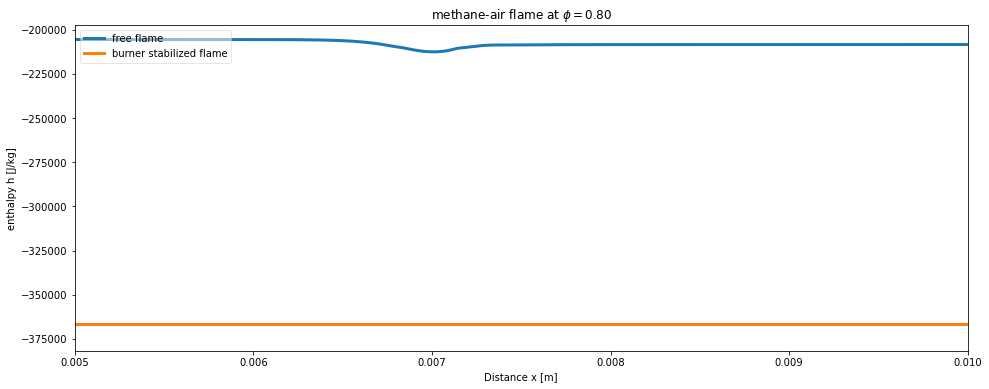

In [57]:
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [16, 6]
plt.xlim(0.005,0.01)
plt.plot(f.grid,f.enthalpy_mass,label='free flame')
plt.plot(f_burner.grid,f_burner.enthalpy_mass,label='burner stabilized flame')
plt.title('methane-air flame at $\phi=0.80$')
plt.xlabel('Distance x [m]')
plt.ylabel('enthalpy h [J/kg]')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper left')
plt.show()

We see that for the free flame as well as the burner stabilized flame, the total enthalpy is constant in the entire domain.
We now have two methods to change the enthalpy: we can change the inlet temperature of the unburnt mixture in a free flame or we can change the mass flow rate of a burner stabilized flame. 

The total enthalpy is an important parameter of the flame. For unity Lewis number flames and a given state (equivalence ratio and pressure), the temperature and composition of the mixture is a unique function of only the *progress of combustion* and the total enthalpy. The progress of combustion can be modeled using for instance the mass fraction of $CO_2$: if $Y_{CO_2}=0$, then the mixture is unburnt, and if $Y_{CO_2}=Y_{CO_{2}^{\textrm{max}}}$ then the mixture is completely burnt. $Y_{CO_2}$ is then called a *progress variable*. Some limitations exist, the most important being that the progress variable has to be the slowest variable, so all other quantities have reached their final steady state before the progress variable does. 
Nevertheless, for e.g. local temperatures or the concentration of CO this is a huge advantage because these quantities can be found independent of the actual geometry. The only information we need is the local enthalpy and the local progress variable.


We will now introduce making 2D contour plots. We can make a contour plot of the temperature as function of the progress variable and the heat loss.

In [58]:
T_unburnt_list = [300,400,500,600]
flamelist = []
for T_unburnt in T_unburnt_list:
    print("Tu = ",T_unburnt)
    p = ct.one_atm  # pressure [Pa]
    width = 0.03  # m
    loglevel = 0  # amount of diagnostic output (0 to 8)

    gas = ct.Solution('gri30.xml')

    phi = 0.80
    fuel_species = 'CH4'
    air_composition='O2:0.21,N2:0.79'
    gas.TP = T_unburnt,p
    gas.set_equivalence_ratio(phi,fuel_species,air_composition)

    # Set up flame object
    f = ct.FreeFlame(gas, width=width)
    f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)

    # Solve with mixture-averaged transport model
    f.transport_model = 'UnityLewis'
    f.solve(loglevel) # don't use 'auto' on subsequent solves
    flamelist.append(f)

Tu =  300
Tu =  400
Tu =  500
Tu =  600


we will call the progress variable $c$ and we want to show the contour plot of $T(h,c)$. Python needs to know how to color-fill the space between the data points. For this it needs to know the neighbors of each point (the *connectivity*). If the date is structured, then we have a data array with $N_x$ points in x-direction and $N_y$ points in the y-direction and the neighboring point in the array (either in the row or column) is also the neighboring point in the contour plot. For unstructured meshes, we need to give python information about the connectivity of the points. Because we have used adaptive mesh refinement to compute the flame, each flame solution can have a different number of points $N_x$, so we are dealing here with unstructured data.  We can let python compute the connectivity by giving it the list of all coordinates and it's values, $(x,y,T)$ or in our case, $(h,c,T)$


Below is an example of a 2D contour plot that can be used to visualize changes due to progress variable or enthalpy. Only 4 flames ar eused to construct the contour plot, so the accuracy is low for fields with large gradients.

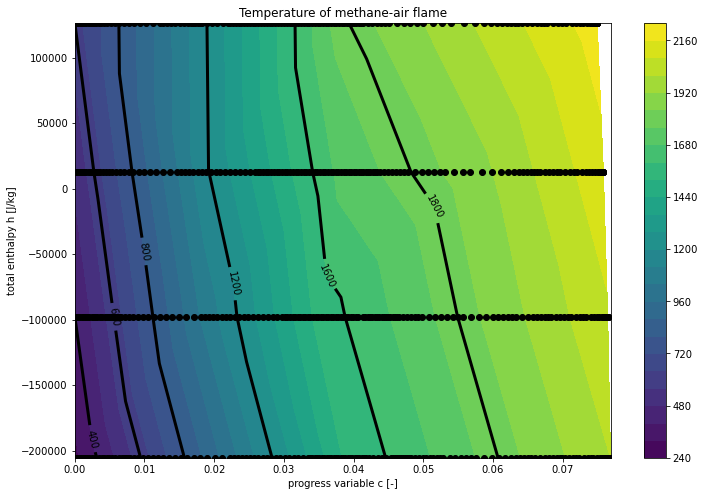

In [59]:
import matplotlib.tri as tri

# initialize the empty arrays
H = np.array([],dtype=float)
c = np.array([],dtype=float)
T = np.array([],dtype=float)

# loop over flames and compute all the coordinates H,c and the values T
for flame in flamelist:
    h = np.full(len(flame.grid),flame.enthalpy_mass[0])
    H = np.concatenate((H,h))
    c = np.concatenate((c,flame.X[gas.species_index('CO2')]))
    T = np.concatenate((T,flame.T))

plt.rcParams['figure.figsize'] = [12, 8]

# Define black line contour levels in temperature where we want lines to appear
levels = np.array([400,600,800,1200,1600,1800])

fig, ax = plt.subplots()
ax.set_title('Temperature of methane-air flame')
ax.set_xlabel('progress variable c [-]')
ax.set_ylabel('total enthalpy h [J/kg]')
tcf = ax.tricontourf(c,H,T, 30) # contour plot, using xx number of contour levels

# Set all level lines to black
line_colors = ['black' for l in tcf.levels]
cp = ax.tricontour(c, H, T, levels=levels, colors=line_colors)
# format of label text on the contour lines, it is a float (real) with 0 digits. Positioning is automatic
ax.clabel(cp, fontsize=10, fmt='%.0f',colors=line_colors)
# colorbar
fig.colorbar(tcf)

# visualize data points
ax.plot(c,H, 'ko')

plt.show()

In the example above, the data was unstructured. It is usually easier to convert this data to a structured mesh, where every row and column of data has the same number of datapoints. We will look at that in another module.

## Assignment 3.1
- Plot the laminar flame speed and flame temperature as a function of equivalence ratio $S_L(\phi)$ for the range $\phi=0.6 - 1.2$. Describe the result in the cell below the figure. Where does the maximum occur? 
- Change the mixing model from unity lewis to mixture averaged and plot $S_L(\phi)$ in the same figure as the unity Lewis results. Comment on the range of applicability of the unity Lewis number model.
- Solve a free flame for $\phi=0.6$ and plot the following 4 figures, comment on the results and then comment on the idea of using the mass fraction of $CO_2$ as a method to uniquely describe all flame properties.
    - $Y_{CO_2},Y_{CH_4},Y_{O_2},Y_{H_2O}$ as a function of the progress variable $Y_{CO_2}$. 
    - $Y_O,Y_H,Y_{OH},Y_{CH_3}$ as a function of the progress variable $Y_{CO_2}$. 
    - $Y_{NO}$ as a function of the progress variable $Y_{CO_2}$. 
    - $Y_{CO}$ as a function of the progress variable $Y_{CO_2}$. 
- For $\phi=0.6$, compute a free flame and a burner stabilized flame and try to match the total enthalpy of both flames by modifying the mass flow rate. Compare $Y_{CO}(x)$ and the net production rate of $CO_2$, $S_{CO_2}(x)$ for both flames. Comment on the differences.